# Inversion of pattern-forming PDE: Gierer-Meinhardt system

This notebook requires the new bayesflow package, currently found on the BayesFlow dev branch as of 3. December 2024.
It can be installed by uncommenting the following line.

In [1]:
#!pip install git+https://github.com/bayesflow-org/bayesflow.git@dev

In [2]:
import os

os.chdir("..")

In [3]:
import bayesflow as bf
import keras

2024-12-04 13:46:34.068755: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 13:46:34.071557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 13:46:34.079745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 13:46:34.092166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 13:46:34.095811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 13:46:34.106527: I tensorflow/core/platform/cpu_feature_gu

In [4]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "no"
from juliacall import Main as jl

jl.seval('import Pkg; Pkg.activate(".")')

jl.seval('include("src/modules.jl")')

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/code/PatternInference`


Main.GMStabilityAnalysis

In [5]:
jl.seval("using Distributions")

jl.seval("import .GiererMeinhardt")
jl.seval("import .GMStabilityAnalysis")
jl.seval("using .Samplers")

# Gierer Meinhardt System

The Gierer-Meinhardt system was proposed by Gierer and Meinhardt in 1972 and is a reaction-diffusion system of the activator-inhibitor type that appears to account for many important types of pattern formation and morphogenesis observed in development of organisms.

It is an example system showing diffusion driven (Turing) instability and consists of two chemicals that can react and have a different diffusion constant.

To see how the concentrations $u_1$ and $u_2$ subject to reaction and diffusion change, refer to the PDE

$$
\begin{align}
\partial_t u_1 =& a - b u_1 + \frac{u_1 ^2} {u_2 (1+c u_1^2)} &+ s \Delta u_1 \\
\partial_t u_2 =& u_1 ^2 - u_2 &+ \delta s \Delta u_2
\end{align}
$$ where $a$, $b$, $c$ and $\delta$ are unknown positive parameters.

To combine such structural knowledge (or hypothesis) with experimental data, we require to solve the following inverse problem:
Given an observation, determine all the model configurations that are able to produce it. In other words, what is the posterior probability $p(\theta|x_{obs})$ of all model configurations $\theta=(a, b, c, \delta)$ given some (set of) experimental data $x_{obs}$.

Classical statistical approaches like MCMC or ABC are infeasable as the likelihood density is not available, sampling it is still expensive and we lack a sensible distance measure in observation space (images of patterns). Consequentially, this problem has motivated the search for new methods based on e.g. hand-crafted Resistance Distance Histogram (RDH) statistics [1], or an artificial Correlation Integral Likelihood (CIL) applicable for a batch of observations [2], among others.

    [1] Schnörr, D., & Schnörr, C. (2021).
        Learning System Parameters from Turing Patterns
        (No. arXiv:2108.08542). arXiv. http://arxiv.org/abs/2108.08542
    
    
    [2] Kazarnikov, A., Scheichl, R., Haario, H., & Marciniak-Czochra, A. (2023).
        A Bayesian Approach to Modelling Biological Pattern Formation with Limited Data
        (No. arXiv:2203.14742). arXiv. http://arxiv.org/abs/2203.14742

This notebook presents the treatment by amortized Bayesian inference (ABI).

For this we require the ability to sample from the generative process. It consists of priors for the parameters and initial conditions and a likelihood which will be a PDE solve operation.

## Prior

In [6]:
def prior():
    """
    Sample from prior for a, b, c, delta, s, delta_x as in to [1].

    [1] Schnörr, D., & Schnörr, C. (2021).
        Learning System Parameters from Turing Patterns
        (No. arXiv:2108.08542). arXiv. http://arxiv.org/abs/2108.08542
    """
    parameters = np.array(jl.wide_prior_sampler())
    return dict(parameters=parameters)


def filtered_sampler(sampler, filter_function):
    candidate_sample = sampler()
    while not filter_function(candidate_sample):
        candidate_sample = sampler()
    return candidate_sample


def filtered_prior():
    """Rejects all parameter vectors that do not exhibit diffusion driven instability."""
    parameters = np.array(filtered_sampler(jl.wide_prior_sampler, jl.GMStabilityAnalysis.is_homogeneous_state_unstable))
    return dict(parameters=parameters)

## Initial conditions

In [7]:
def ic_sampler(parameters, domain_size=64):
    """Initializes the field with random perturbation around the fix point of the perfectly mixed system"""
    homogeneous_fix_point = np.array(jl.GMStabilityAnalysis.homogeneous_state(parameters))

    initial_conditions = homogeneous_fix_point[None, None, :] * (
        1 + 0.01 * np.random.rand(domain_size, domain_size, len(homogeneous_fix_point))
    )
    return dict(initial_conditions=initial_conditions)

## Solve partial differential equation

The PDE forward evolution is computationally expensive. We thus use fairly optimized solver code written in Julia that uses the powerful [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/dev/) package with a [Sundials](https://computing.llnl.gov/projects/sundials) solver.

In [8]:
def solve_final_state(parameters, initial_conditions, tspan=(0, 1000)):
    prob = jl.GiererMeinhardt.initialize_problem(jl.Array(parameters), jl.Array(initial_conditions), tspan)
    sol = jl.solve_final_state(
        jl.Array(parameters),
        jl.Array(initial_conditions),
        tspan,
        prob,
    )
    final_state = sol.u[-1][:, :, 0]
    return dict(final_states=final_state)

# Combine components into a simulator

In [9]:
simulator = bf.make_simulator([filtered_prior, ic_sampler, solve_final_state])  # , solve_final_state])

In [36]:
%%time
test_sims = simulator.sample(batch_size=3)
print(test_sims["parameters"].shape)
print(test_sims["initial_conditions"].shape)
print(test_sims["final_states"].shape)

(3, 5)
(3, 64, 64, 2)
(3, 64, 64)
CPU times: user 21.3 s, sys: 30.4 ms, total: 21.4 s
Wall time: 21.3 s


In [37]:
# %%time # todo: parallelize online PDE solves. Currently SciML.jl's EnsembleProblem seems to have a memory leak
# when called from IPython that terminates the jupyter kernel.

# ens_sol = jl.solve_final_states_ensemble(
#    test_sims["parameters"],
#    test_sims["initial_conditions"],
#    (0, 1000), jl.GiererMeinhardt.initialize_problem
# )

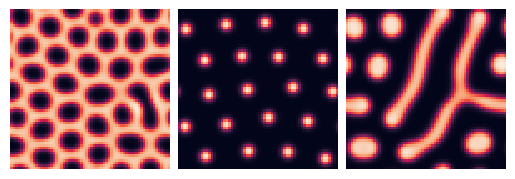

In [38]:
num_pattern_plots = 3
fix, ax = plt.subplots(1, num_pattern_plots)
for i in range(num_pattern_plots):
    img = sns.heatmap(test_sims["final_states"][i, :, :], ax=ax[i], square=True, cbar=False)
    img.set_xticks([])
    img.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)

Those patterns above are simulated here in the notebook. Calling the simulator is too slow for online training, so I prepared offline datasets for training and validating which we will load next.

# Load prepared simulations 

In [13]:
training_budget = None  # None -> no cropping, use all available data.

In [14]:
def add_individual_sim_data_std(data_dict):
    "Adds a pattern standardized to stretch between -1 and 1 as a key value pair to `data_dict`."
    individual_minimum = np.min(
        data_dict["final_states"],
        axis=(
            1,
            2,
        ),
        keepdims=True,
    )
    individual_maximum = np.max(
        data_dict["final_states"],
        axis=(
            1,
            2,
        ),
        keepdims=True,
    )
    individual_ptp = individual_maximum - individual_minimum

    data_dict["final_states_std"] = ((data_dict["final_states"] - individual_minimum) / individual_ptp - 0.5) * 2


SIMS_PATH_TRAIN = "data/GM-001-slice-04000-12192-train.pkl"
with open(SIMS_PATH_TRAIN, "rb") as f:
    train_dict = pickle.load(f)
    train_dict["parameters"] = train_dict["parameters"][:, :4]
    add_individual_sim_data_std(train_dict)

    train_dict = {key: value[:training_budget, ...] for key, value in train_dict.items()}

SIMS_PATH_VAL = "data/GM-001-slice-00000-02000-validation.pkl"
with open(SIMS_PATH_VAL, "rb") as f:
    val_dict = pickle.load(f)
    val_dict["parameters"] = val_dict["parameters"][:, :4]
    add_individual_sim_data_std(val_dict)

for new_data_dict in (train_dict, val_dict):
    for key, value in new_data_dict.items():
        print(f"{key:20s} shape={str(value.shape):18s} min={np.min(value)}")
    print()

final_states         shape=(8192, 64, 64)     min=0.0052894427025144955
initial_conditions   shape=(8192, 2, 64, 64)  min=0.09664014160762038
parameters           shape=(8192, 4)          min=0.010001311912456666
final_states_std     shape=(8192, 64, 64)     min=-1.0

final_states         shape=(2000, 64, 64)     min=0.005986330524587994
initial_conditions   shape=(2000, 2, 64, 64)  min=0.09807058792046151
parameters           shape=(2000, 4)          min=0.010124940654895923
final_states_std     shape=(2000, 64, 64)     min=-1.0



## Look at some presimulated data

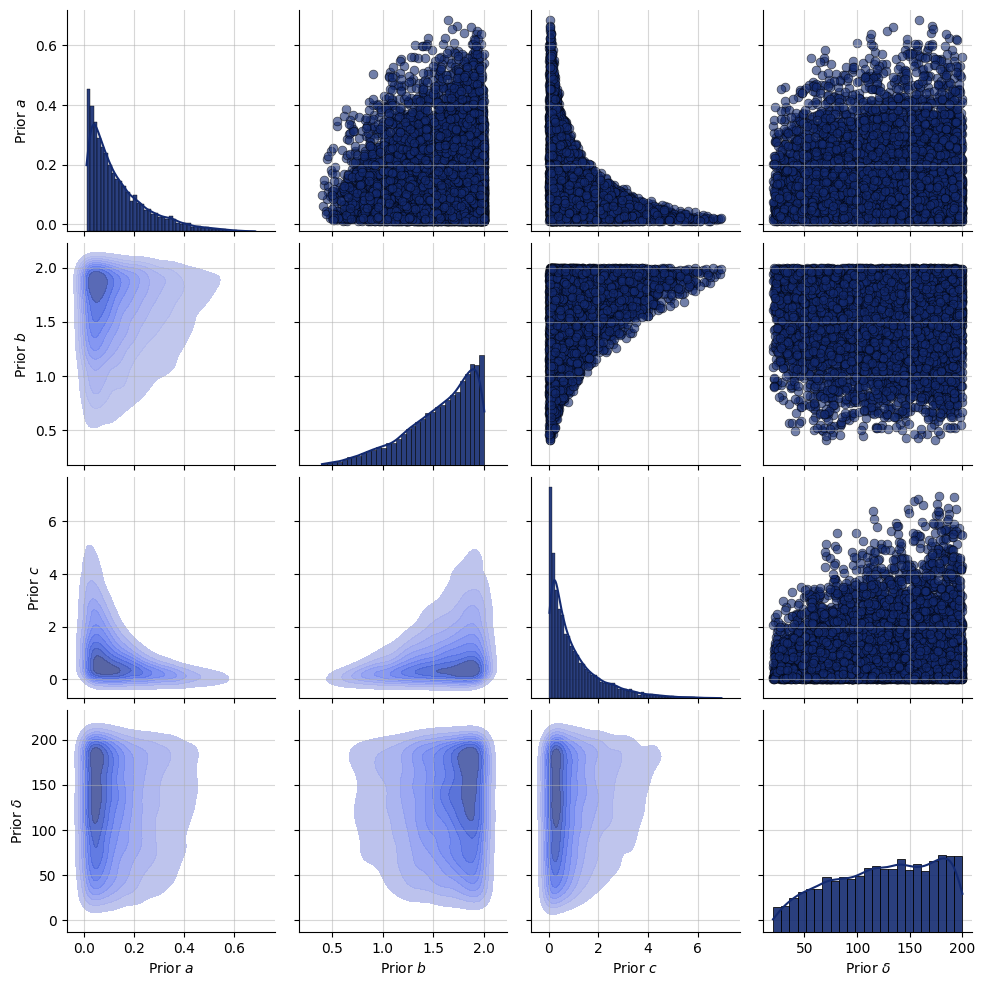

In [15]:
variable_names = np.array(["$a$", "$b$", "$c$", r"$\delta$"])
bf.diagnostics.plot_samples_2d(train_dict, context="Prior", filter_keys=["parameters"], variable_names=variable_names)

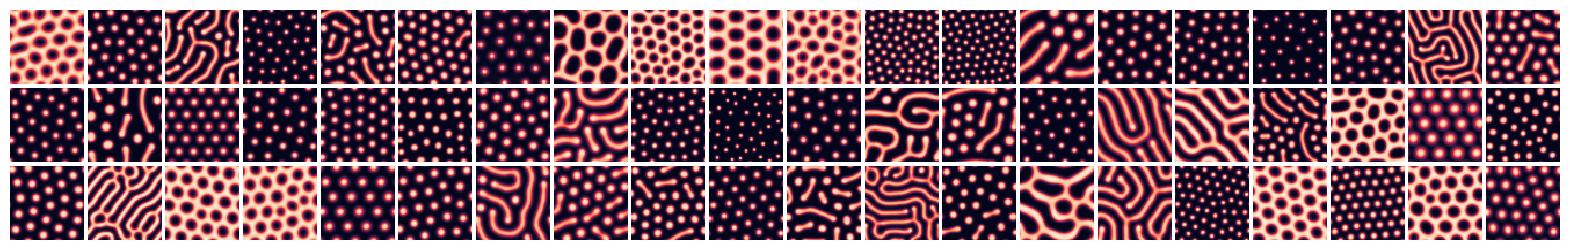

In [16]:
num_pattern_plots = 60
columns = 20
num_h, num_v = num_pattern_plots // columns, columns
fix, axes = plt.subplots(num_h, num_v, figsize=(num_v, num_h))
for i, ax in enumerate(axes.flatten()):
    img = sns.heatmap(train_dict["final_states_std"][i], ax=ax, square=True, cbar=False)  # , cmap="icefire")
    img.set_xticks([])
    img.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Preprocessing

In [17]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .keep(["parameters", "final_states_std"])
    .constrain("parameters", lower=0)
    .rename("parameters", "inference_variables")
    .rename("final_states_std", "summary_variables")
    # .standardize(include="inference_variables", momentum=None, axis=0)
    .standardize(momentum=None)  # exclude=["patterns", "patterns_std"])
)

`OfflineDataset` objects will store both the training and the validation dataset, perform the adaptation and serve it batchwise with a fixed size.

In [18]:
batch_size = 32

training_dataset = bf.datasets.OfflineDataset(data=train_dict, batch_size=batch_size, adapter=adapter)

validation_dataset = bf.datasets.OfflineDataset(data=val_dict, batch_size=batch_size, adapter=adapter)

In [19]:
training_dataset.__getitem__(0)["summary_variables"].shape

/home/ho/programs/anaconda3/envs/pattern-experiments/lib/python3.10/site-packages/bayesflow/utils/numpy_utils.py:19: RuntimeWarning: overflow encountered in expm1
  return np.where(beta * x > threshold, x, np.log(beta * np.expm1(x)) / beta)


(32, 64, 64)

In [20]:
np.seterr(over="ignore")  # ignore those overflow warnings since they are already caught by np.where

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Build a CNN to summarize patterns

In [21]:
class PatternSummary(bf.networks.SummaryNetwork):
    def __init__(
        self,
        summary_dim,
        conv_params,
        num_fully_connected=15,
        conv_dropout_prob=0.0,
        dense_dropout_prob=0.0,
        kernel_regularizer="l1l2",
        **kwargs,
    ):
        """
        Create a pattern summary network with flexible convolutional layers, max-pooling, and dropout.

        Parameters
        ----------
        summary_dim : int
            The dimension of the summary statistics.
        conv_params : list of dict
            A list of dictionaries defining the parameters for convolutional layers, e.g.:
                - num_filters: int, number of filters for the Conv2D layer.
                - kernel_size: int or tuple, size of the kernel for the Conv2D layer.
                - pool_size: int or tuple, size of the max-pooling window (optional).
                - activation: str, activation function (default is 'relu').
        num_fully_connected : int, optional
            The number of units in the fully connected layer (default is 15).
        conv_dropout_prob : float, optional
            The dropout probability applied after each convolutional layer (default is 0.0).
        dense_dropout_prob : float, optional
            The dropout probability applied before the fully connected layer (default is 0.0).
        kernel_regularizer : string or keras.Regularizer object
            Regularization of convolutional and dense layers (default is "l1l2")
        kwargs : dict, optional
            Additional keyword arguments for the tf.keras.Model superclass.
        """
        super().__init__(**kwargs)
        self.summary_dim = summary_dim

        self.net = keras.models.Sequential()
        self.net.add(keras.layers.Lambda(lambda x: keras.ops.expand_dims(x, axis=-1)))

        for conv_param in conv_params:
            num_filters = conv_param.get("num_filters", 32)
            kernel_size = conv_param.get("kernel_size", 3)
            activation = conv_param.get("activation", "relu")
            pool_size = conv_param.get("pool_size", None)

            self.net.add(
                keras.layers.Conv2D(
                    num_filters, kernel_size, activation=activation, kernel_regularizer=kernel_regularizer
                )
            )

            if pool_size is not None:
                self.net.add(keras.layers.MaxPooling2D(pool_size))

            if conv_dropout_prob > 0:
                self.net.add(keras.layers.Dropout(conv_dropout_prob))

        self.net.add(keras.layers.Flatten())
        if dense_dropout_prob > 0:
            self.net.add(keras.layers.Dropout(dense_dropout_prob))
        self.net.add(keras.layers.Dense(num_fully_connected, activation="relu", kernel_regularizer=kernel_regularizer))
        self.net.add(keras.layers.Dense(summary_dim, kernel_regularizer=kernel_regularizer))

    def call(self, inputs, training: bool = False, **kwargs):
        return self.net(inputs)

In [22]:
conv_params = [
    {"num_filters": 32, "kernel_size": 3, "pool_size": 2},
    #    {"num_filters": 64, "kernel_size": 3, "pool_size": 2},
    {"num_filters": 64, "kernel_size": 3},
]
summary_dim = 6
summary_net_dropout = inference_net_dropout = 0.0
summary_net = PatternSummary(
    summary_dim=summary_dim,
    conv_params=conv_params,
    num_fully_connected=15,
    conv_dropout_prob=summary_net_dropout,
    dense_dropout_prob=summary_net_dropout,
    kernel_regularizer="l1l2",
)

# Setup an inference network for amortized posterior inference

In [23]:
inference_net = bf.networks.FlowMatching(subnet_kwargs={"residual": True, "dropout": inference_net_dropout})
# inference_net = bf.networks.CouplingFlow()

In [24]:
approximator = bf.approximators.ContinuousApproximator(
    inference_network=inference_net, summary_network=summary_net, adapter=adapter
)

# Construct optimization problem

In [25]:
epochs = 15

In [26]:
initial_learning_rate = 5e-4
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=epochs * training_dataset.num_batches, alpha=1e-8
)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lr, clipnorm=1.0)
approximator.compile(optimizer=optimizer)

In [27]:
history = approximator.fit(
    epochs=epochs,
    dataset=training_dataset,
    validation_data=validation_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 1.5503 - loss/inference_loss: 1.5503 - val_loss: 1.7924 - val_loss/inference_loss: 1.7924
Epoch 2/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 1.0617 - loss/inference_loss: 1.0617 - val_loss: 0.7081 - val_loss/inference_loss: 0.7081
Epoch 3/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.8760 - loss/inference_loss: 0.8760 - val_loss: 1.1504 - val_loss/inference_loss: 1.1504
Epoch 4/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.7931 - loss/inference_loss: 0.7931 - val_loss: 1.3238 - val_loss/inference_loss: 1.3238
Epoch 5/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.7434 - loss/inference_loss: 0.7434 - val_loss: 0.9956 - val_loss/inference_loss: 0.9956
Epoch 6/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.7314 - loss/inference_loss: 0.7314 - val_loss: 0.7918 - val_loss/inference_loss: 0.7918
Epoch 7/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.6862 - loss/inference_lo

# Visualize losses


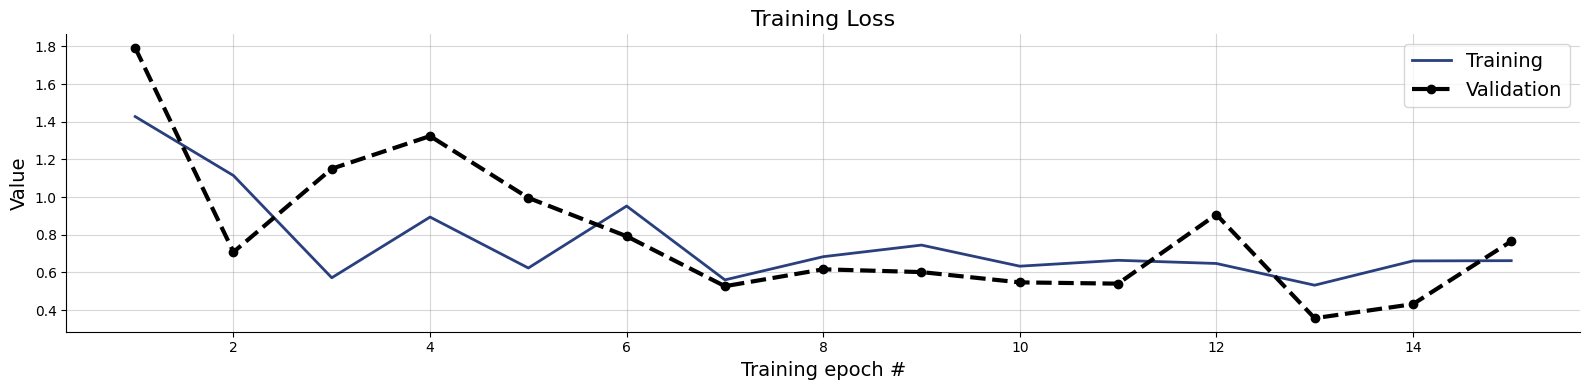

In [28]:
f = bf.diagnostics.plot_losses(
    train_losses=np.array(history.history["loss"]).astype(np.float32),
    val_losses=np.array(history.history["val_loss"]).astype(np.float32),
)

# Diagnosing on held-out validation data

In [29]:
batch_size = 200
num_samples = 500
conditions = {k: v[:batch_size, ...] for k, v in val_dict.items() if k != "parameters"}

pdraws = approximator.sample(conditions=conditions, num_samples=num_samples)
conditions |= pdraws

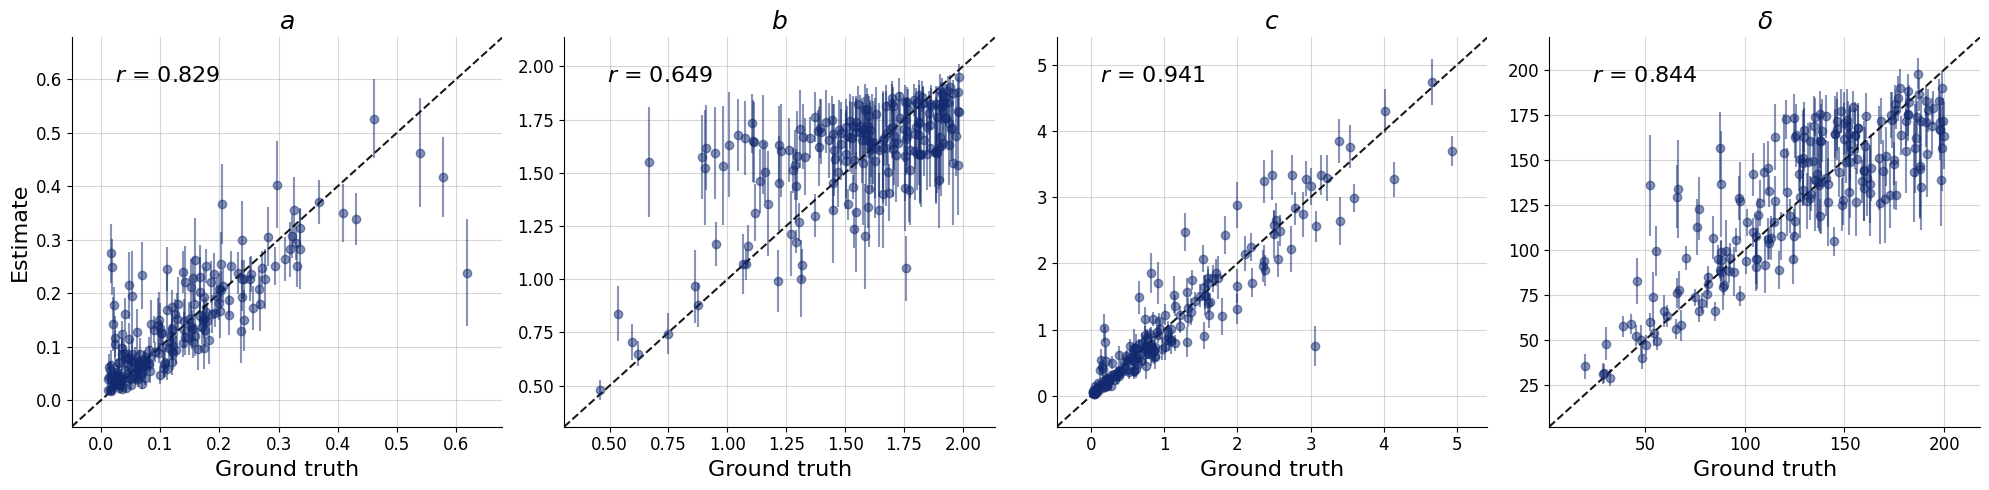

In [30]:
f = bf.diagnostics.plot_recovery(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], variable_names=variable_names
)

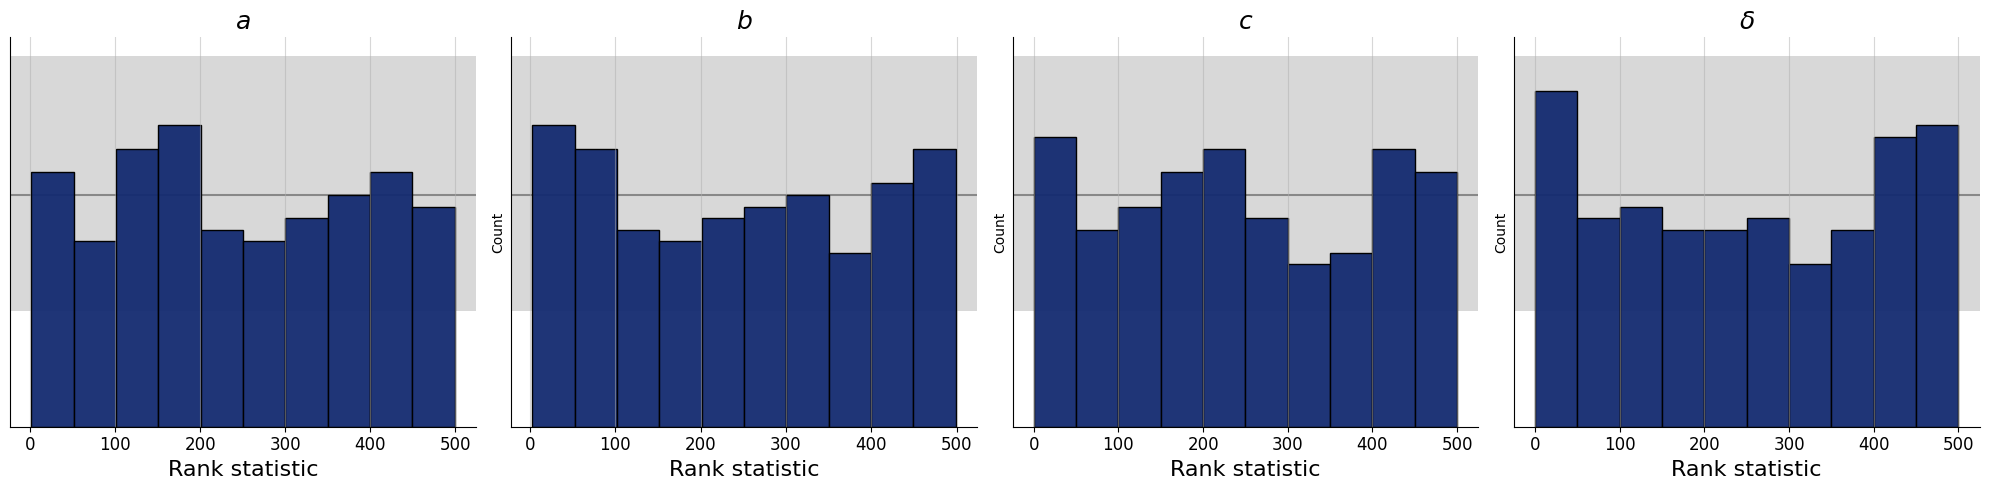

In [40]:
f = bf.diagnostics.plot_sbc_histograms(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], variable_names=np.array(variable_names)
)

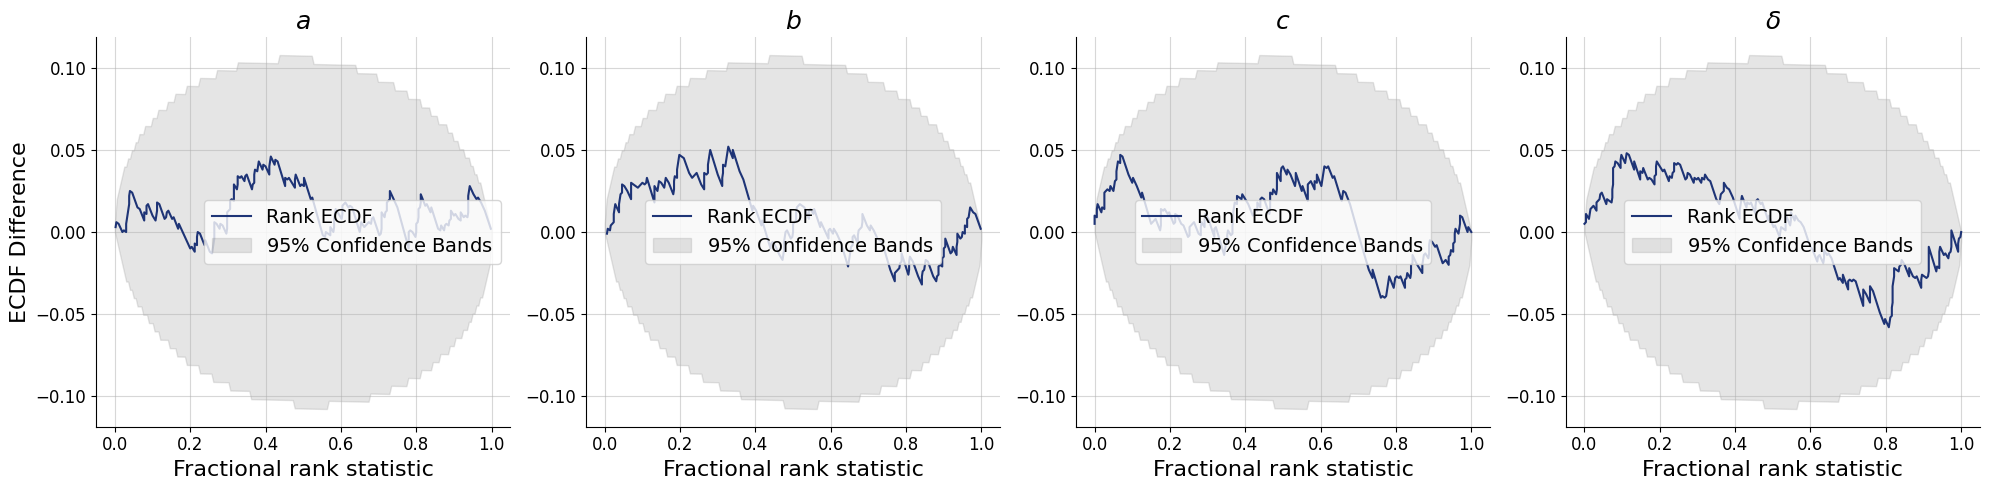

In [32]:
f = bf.diagnostics.plot_sbc_ecdf(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], difference=True, variable_names=variable_names
)

The posteriors are calibrated across the board and the accuracy (recovery) looks good.

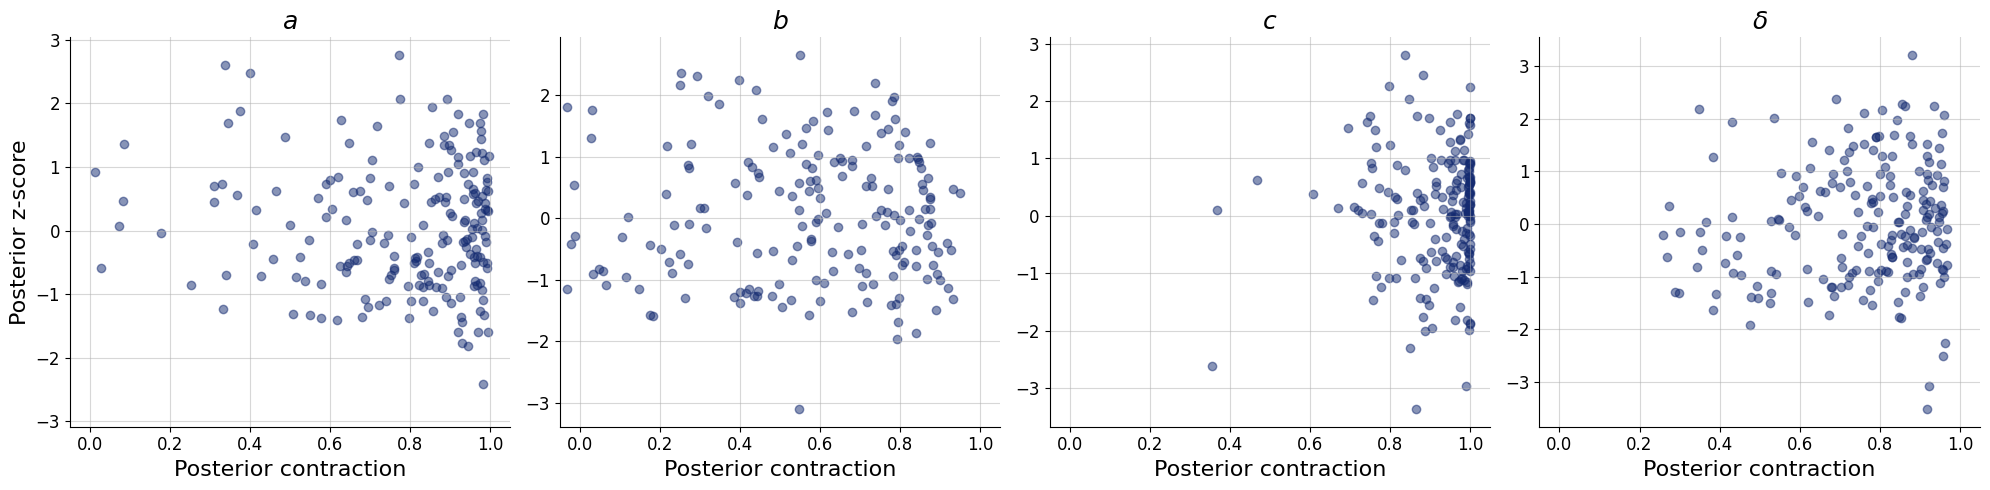

In [39]:
f = bf.diagnostics.plot_z_score_contraction(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], variable_names=variable_names
)

# Inference

If the diagnostics are indicating a trustworthy model, we can continue with harvesting the fruit of our work: inferring full posterior distributions fast. We are using simulated observations here for which we know the true parameter (indicated by a green cross below).

Looking at a few simulated observations can provide an intuition for posterior shapes.

To further scrutinize the infered posteriors, take a look at the posterior predictive samples. Those are the result of generating fresh patterns that correspond to posterior samples. Are they visually similar to the original observation we conditioned on? In line with what we saw in the recovery diagnostic, this shows a mixed picture.

In [41]:
def resimulate(parameters, domain_size=64, tspan=(0, 1000)):
    batch_size = parameters.shape[0]
    final_states = np.empty((batch_size, domain_size, domain_size))

    for i in range(batch_size):
        param_longform = np.concatenate(
            [
                parameters[i],
                [
                    0.5,  # this parameter controls overall scale and was held constant
                ],
            ]
        )
        initial_conditions = ic_sampler(param_longform, domain_size)["initial_conditions"]
        final_states[i] = solve_final_state(param_longform, initial_conditions, tspan)["final_states"]

    return final_states

In [34]:
conditions.keys()

dict_keys(['final_states', 'initial_conditions', 'final_states_std', 'parameters'])

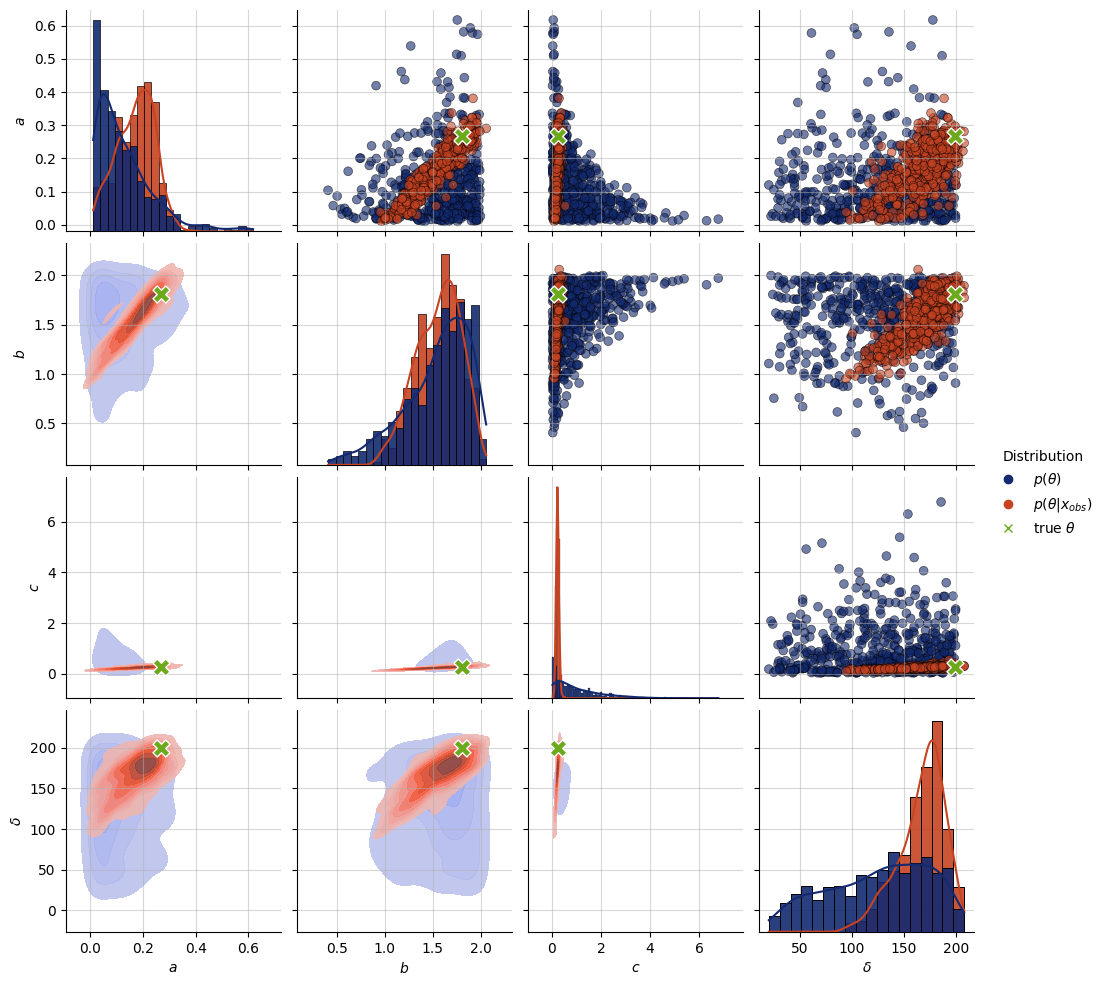

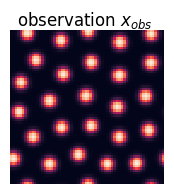

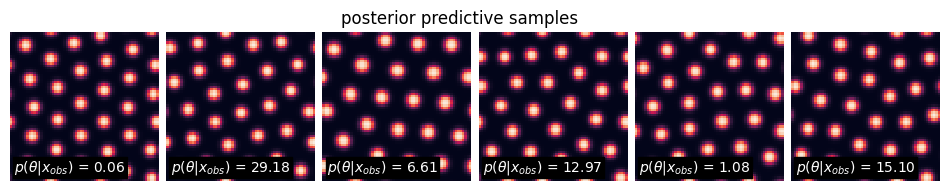

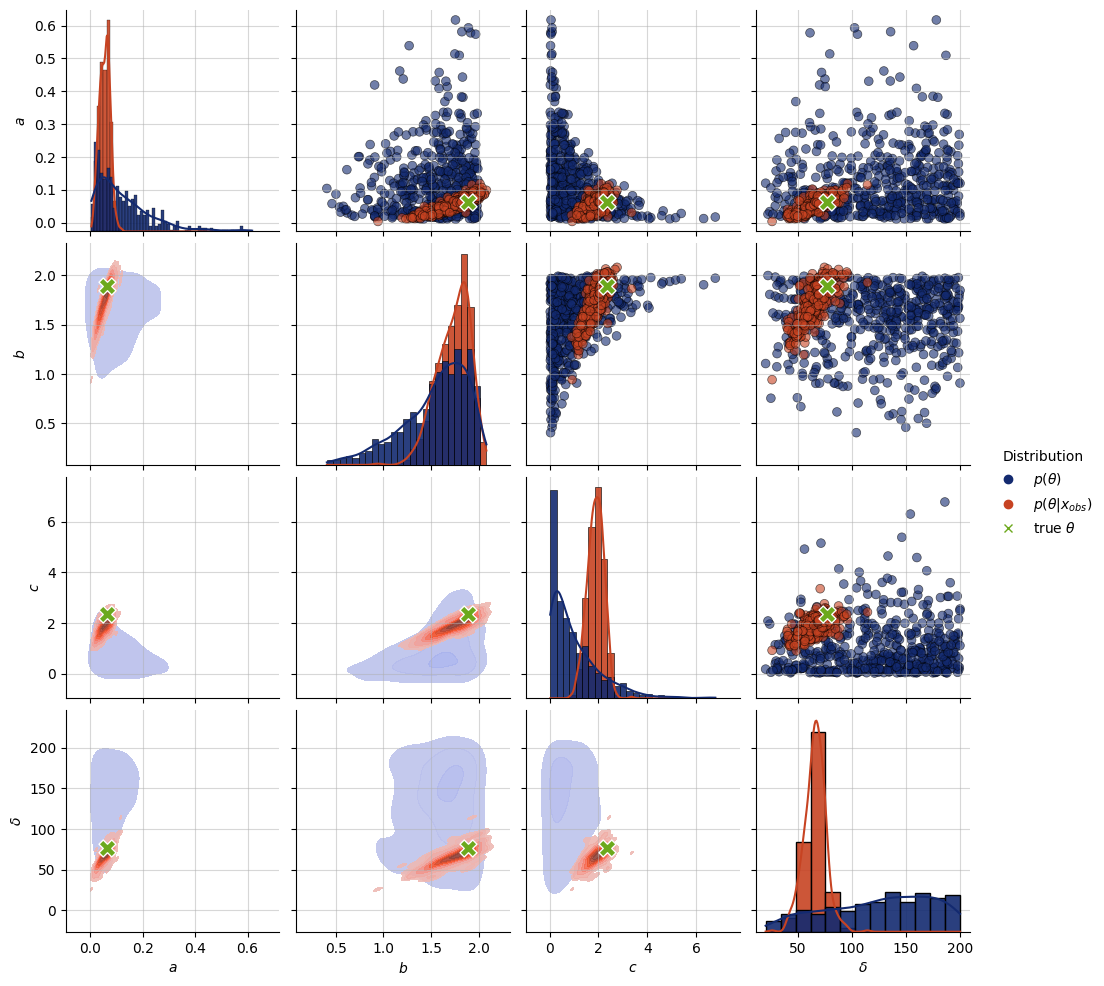

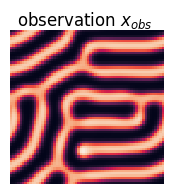

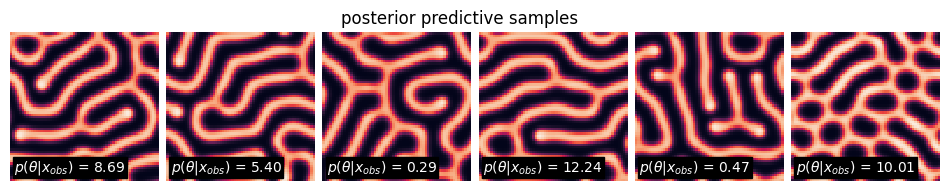

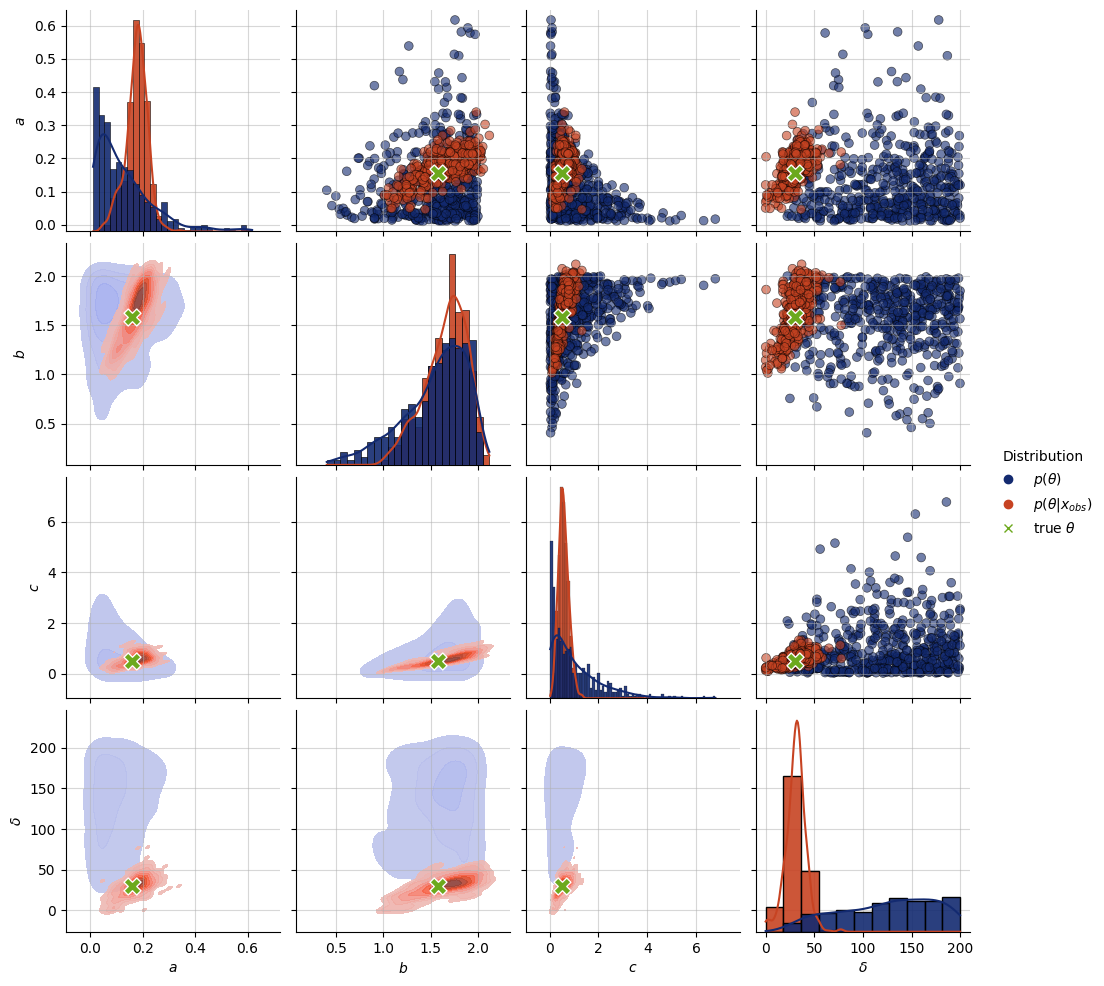

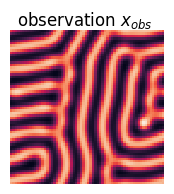

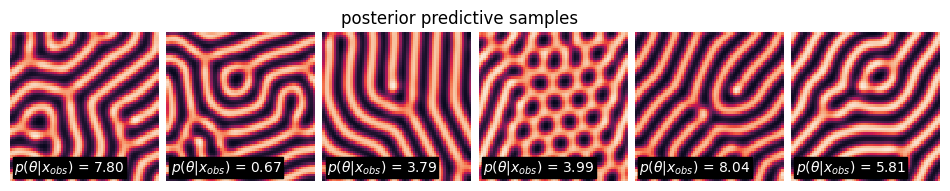

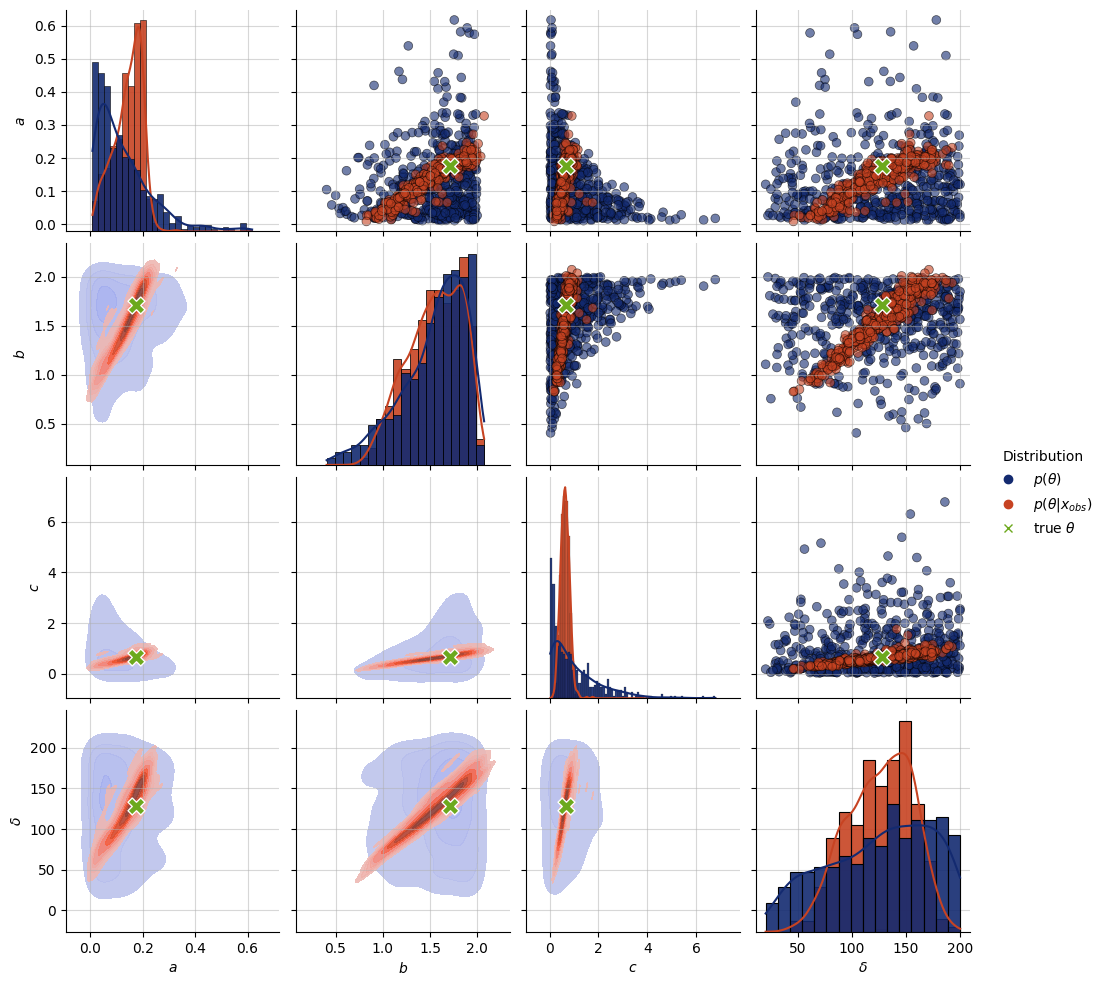

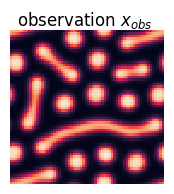

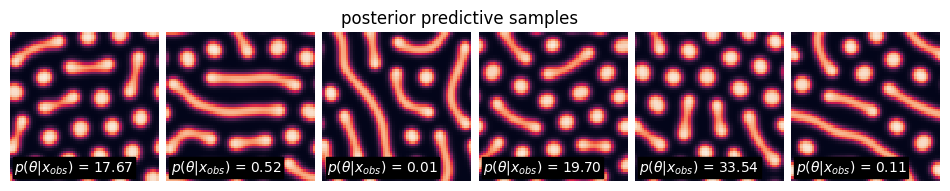

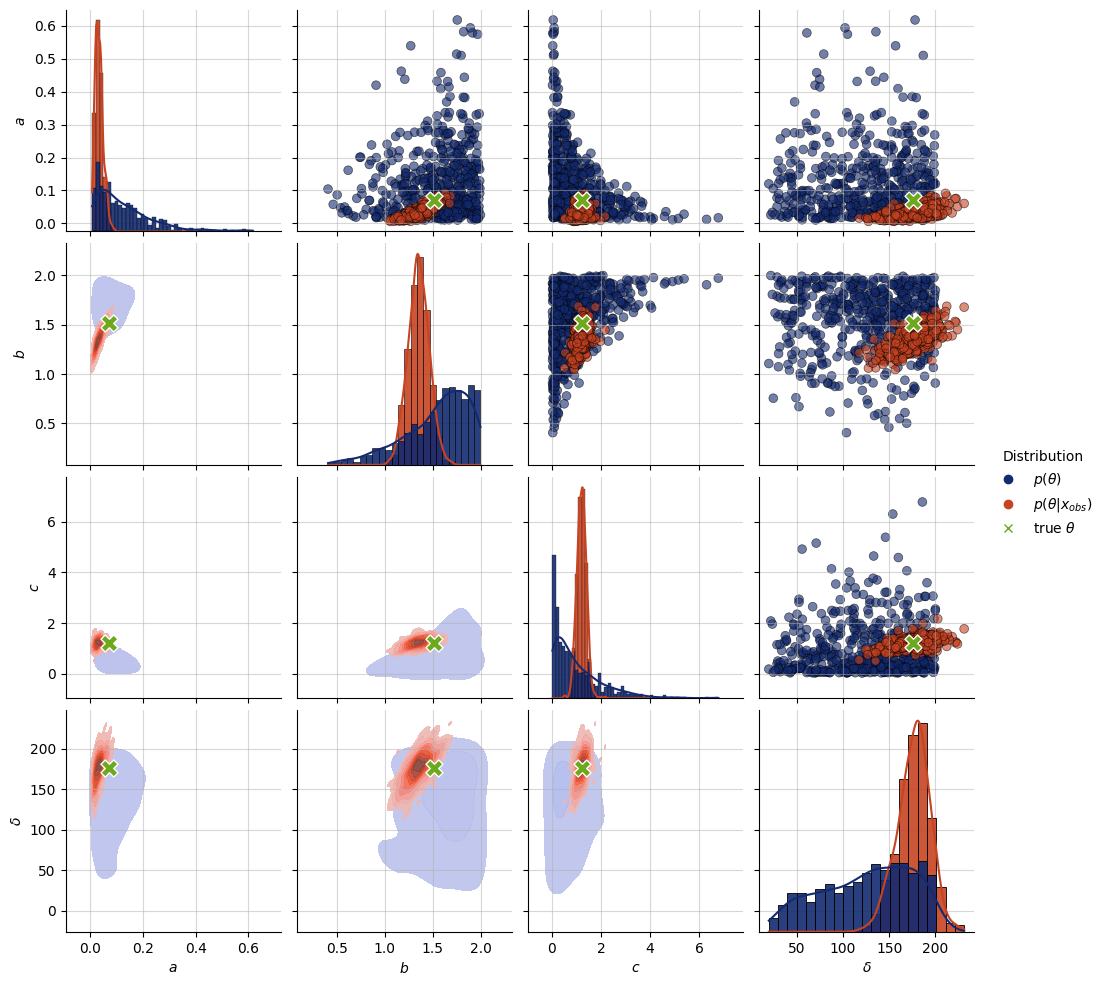

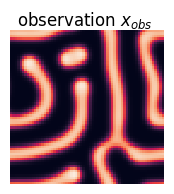

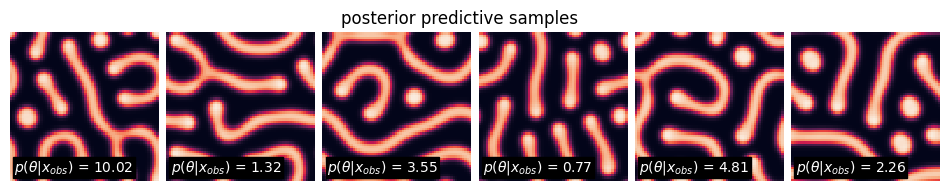

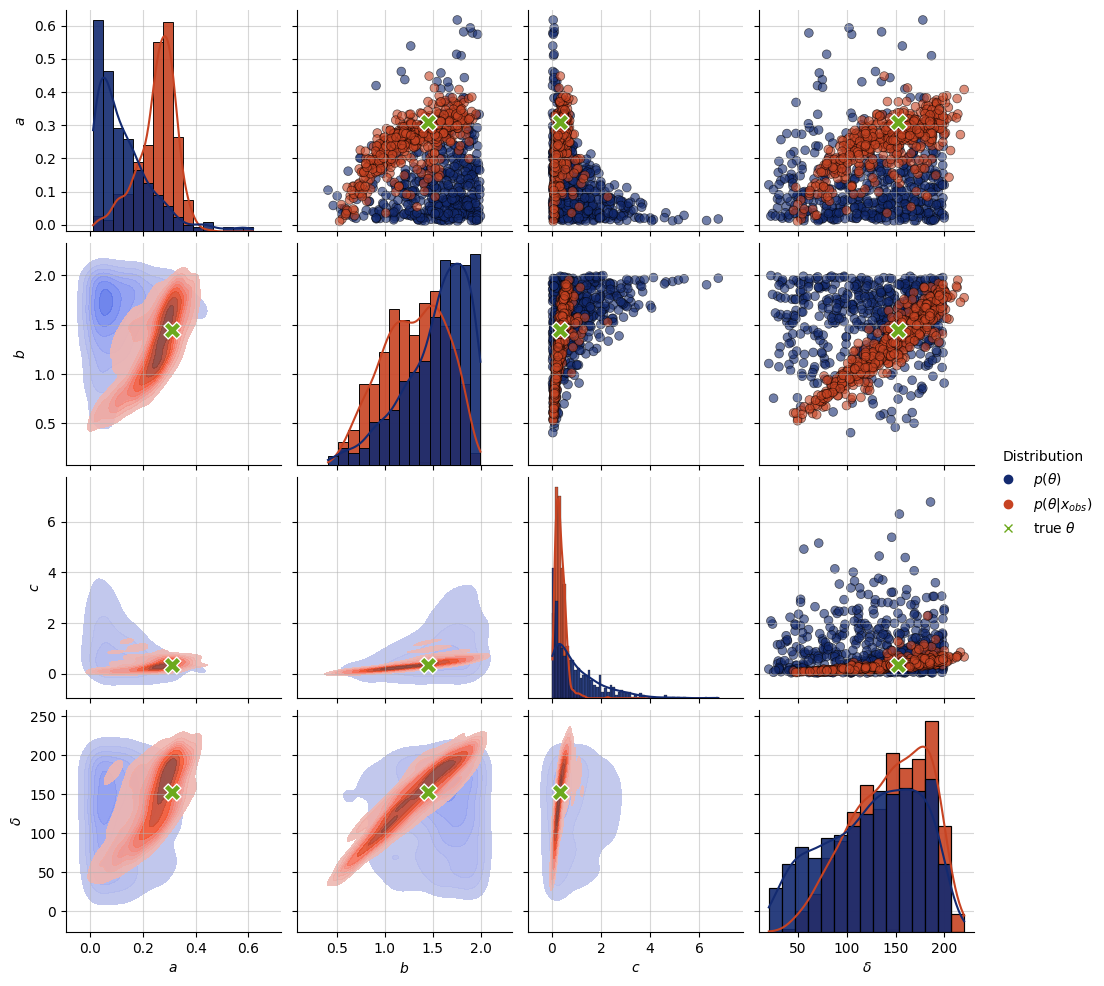

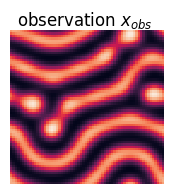

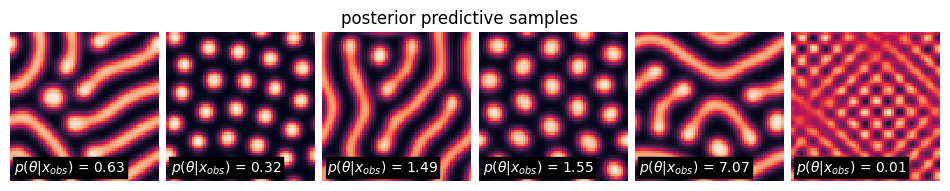

In [35]:
for obs_idx in range(7, 13):

    sample_dict = {}
    sample_dict[r"$p(\theta)$"] = pd.DataFrame(val_dict["parameters"][:num_samples, ...], columns=variable_names)
    sample_dict[r"$p(\theta|x_{obs})$"] = pd.DataFrame(pdraws["parameters"][obs_idx, ...], columns=variable_names)
    sample_dict[r"true $\theta$"] = pd.DataFrame(
        val_dict["parameters"][obs_idx, ...][None, ...], columns=variable_names
    )

    combined_samples = pd.concat(
        [samples.assign(Distribution=label) for label, samples in sample_dict.items()], axis="index", ignore_index=True
    )

    # palette = [sns.color_palette(palette="Set1")[i] for i in [1, 0, 2]]
    palette = ["#132a70", "#C74322", "#6CA91D"]
    g = sns.PairGrid(
        combined_samples, hue="Distribution", diag_sharey=False, palette=palette, height=2.5
    )  # , corner=False)
    g.map_upper(sns.scatterplot, alpha=0.6, s=40, edgecolor="k", marker="o")
    g.map_lower(sns.kdeplot, fill=True, warn_singular=False, bw_adjust=0.9, alpha=0.9)  # , levels=6)
    g.map_diag(sns.histplot, fill=True, alpha=0.9, kde=True)  # , bins=6)

    g.data = combined_samples.iloc[-1:]
    g.map_lower(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)
    g.map_upper(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)

    for i in range(len(variable_names)):
        for j in range(len(variable_names)):
            g.axes[i, j].grid(alpha=0.5)

    handles = [
        Line2D([], [], color=color, ls="", marker=marker, label=label)
        for label, color, marker in zip(combined_samples["Distribution"].unique(), palette, ["o", "o", "x"])
    ]

    g.add_legend(handles=handles)
    g.tight_layout()

    fig, ax = plt.subplots(figsize=(2, 2))
    img = sns.heatmap(val_dict["final_states_std"][obs_idx, ...], ax=ax, square=True, cbar=False)  # , cmap="icefire")
    img.set_xticks([])
    img.set_yticks([])
    fig.suptitle(r"observation $x_{obs}$")
    plt.show()

    num_resims = 6
    resim_params = conditions["parameters"][obs_idx, :num_resims]
    resim_patterns = np.tile(conditions["final_states_std"][obs_idx, :, :], (num_resims, 1, 1))
    log_prob_posterior_samples = np.exp(
        approximator.log_prob(dict(parameters=resim_params, final_states_std=resim_patterns))
    )

    resim_final_states = resimulate(resim_params)

    num_h, num_v = 1, num_resims
    fig, axes = plt.subplots(num_h, num_v, figsize=(num_v * 2, num_h * 2))
    for i, ax in enumerate(axes.flatten()):
        img = sns.heatmap(resim_final_states[i], ax=ax, square=True, cbar=False)  # , cmap="icefire")
        img.set_xticks([])
        img.set_yticks([])
        img.text(
            0.03,
            0.03,
            r"$p(\theta|x_{obs})$ " + f"= {log_prob_posterior_samples[i]:.2f}",
            ha="left",
            va="bottom",
            transform=img.transAxes,
            color="white",
            size=10,
            bbox=dict(facecolor="none", pad=1.0, fc="black"),
        )

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.suptitle("posterior predictive samples")
    plt.show()